# FloPy 

### Working stack demo

A short demonstration of core `flopy` functionality

In [1]:
%matplotlib inline
from IPython.display import clear_output, display
from __future__ import print_function
import time
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.5.2 | packaged by conda-forge | (default, Jan 12 2017, 05:36:40) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.54)]
numpy version: 1.11.3
matplotlib version: 2.0.0
pandas version: 0.19.2
flopy version: 3.2.6


### Model Inputs

In [2]:
# first lets load an existing model
model_ws = os.path.join("..", "data", "freyberg_multilayer_transient")
ml = flopy.modflow.Modflow.load("freyberg.nam", model_ws=model_ws, verbose=False,
                               check=False, exe_name="mfnwt")

In [3]:
ml.dis.sr

xul:619653; yul:3353277; rotation:15; proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2; length_multiplier:1.0

Let's looks at some plots

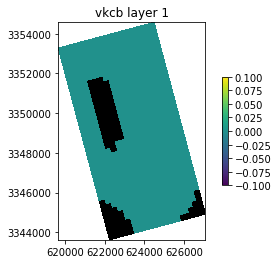

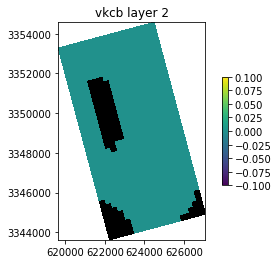

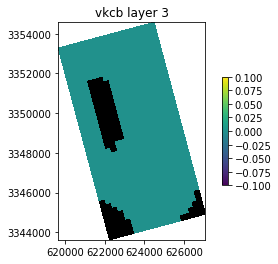

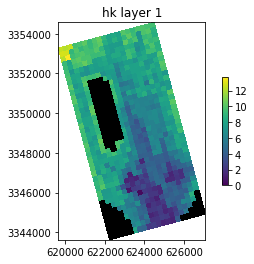

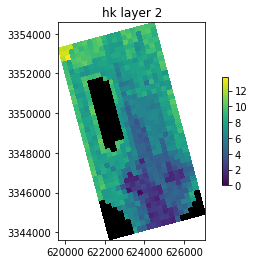

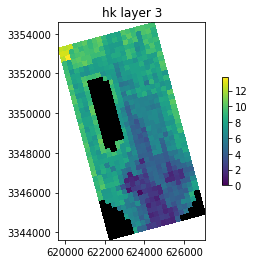

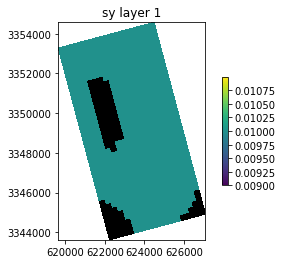

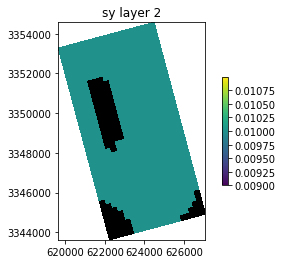

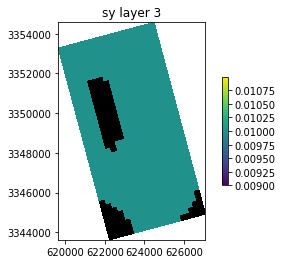

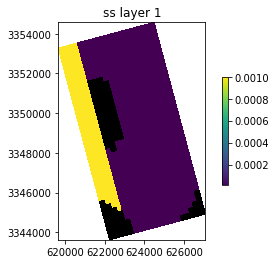

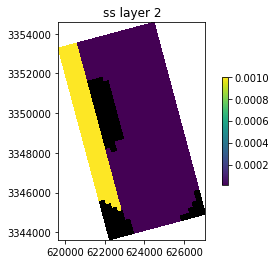

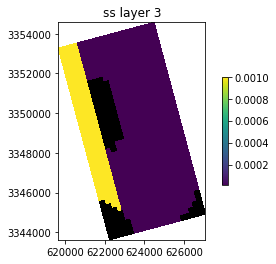

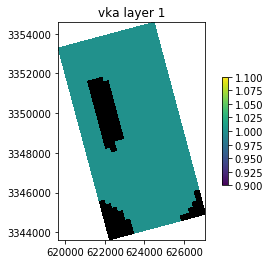

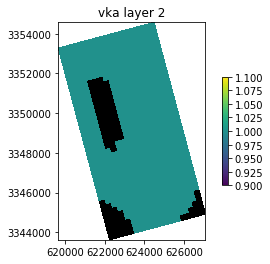

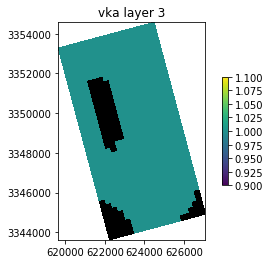

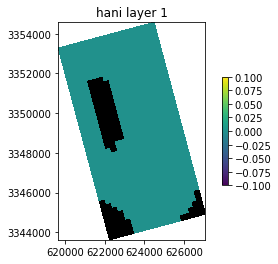

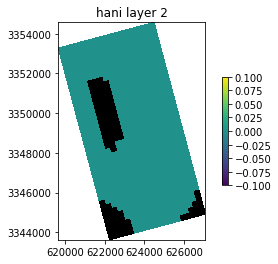

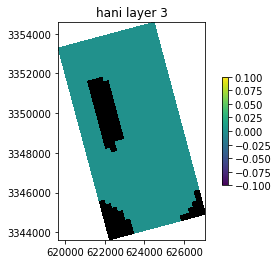

In [4]:
ml.upw.plot();

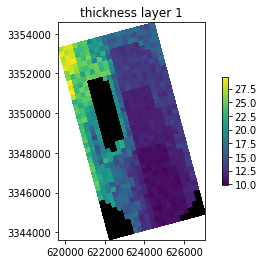

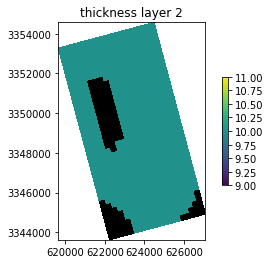

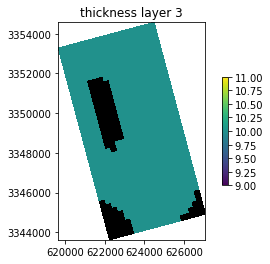

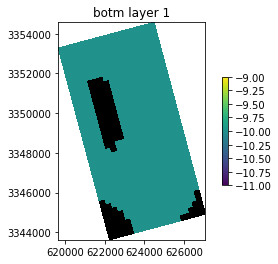

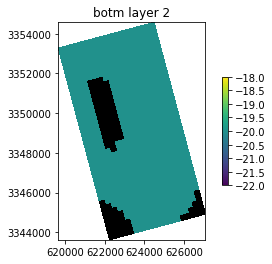

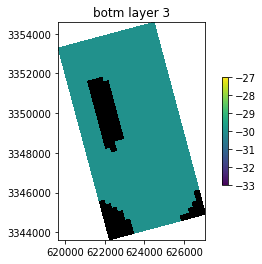

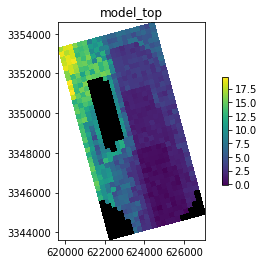

In [5]:
ml.dis.plot();

/Users/jdhughes/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


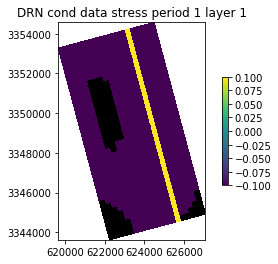

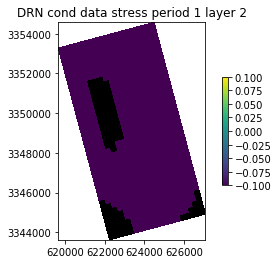

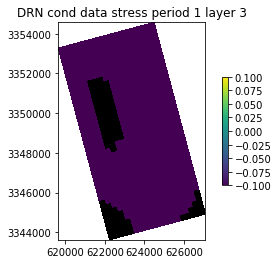

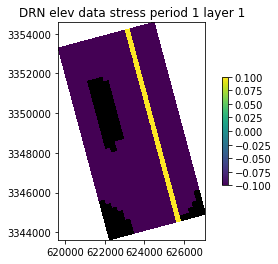

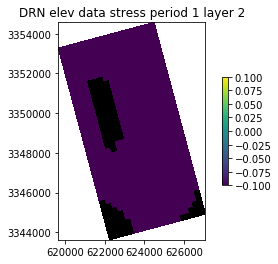

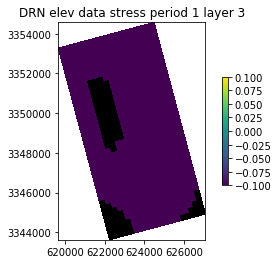

In [6]:
ml.drn.plot(key="cond")
ml.drn.plot(key="elev");


Let's write a shapefile of the DIS package

In [7]:
ml.dis.export(os.path.join('temp',"freyberg_dis.shp"))

wrote temp/freyberg_dis.shp


Let's also write a netCDF file with all model inputs

In [8]:
ml.export(os.path.join('temp', "freyberg.nc"))

### Change model directory, modify inputs and write new input files

In [9]:
ml.external_path = "ref"
ml.model_ws = "temp"


changing model workspace...
   temp


### Run the model

In [10]:
ml.write_input()

ml.run_model()

Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
Util2d:rech_3: resetting 'how' to external
Util2d:rech_4: resetting 'how' to external
Util2d:rech_5: resetting 'how' to external
Util2d:rech_6: resetting 'how' to external
Util2d:rech_7: resetting 'how' to external
Util2d:rech_8: resetting 'how' to external
Util2d:rech_9: resetting 'how' to external
Util2d:rech_10: resetting 'how' to ext

(True, [])

### Output inspection

First, let's look at the list file

In [11]:
mfl = flopy.utils.MfListBudget(os.path.join(model_ws,"freyberg.list"))
df_flux, df_vol = mfl.get_dataframes(start_datetime="10-21-2015")
df_flux

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,DRAINS_IN,RECHARGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,DRAINS_OUT,RECHARGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2015-10-22,0.000000,0.000000,0.0,0.0,6276.861816,6276.861816,0.000000,2446.318848,0.000000,3830.650146,0.0,6276.968750,-0.106900,-0.0
2015-10-23,635.447998,0.000000,0.0,0.0,6428.198730,7063.646484,31.594000,2430.337891,1302.403198,3299.415039,0.0,7063.750000,-0.103500,-0.0
2015-10-24,1361.814941,0.000000,0.0,0.0,5397.295898,6759.110840,9.152200,2369.628174,1618.676392,2761.639648,0.0,6759.096191,0.014648,0.0
2015-10-25,677.577209,0.000000,0.0,0.0,5931.377441,6608.954590,180.233307,2353.585449,1498.694702,2576.461670,0.0,6608.975586,-0.020996,-0.0
2015-10-26,697.818298,0.000000,0.0,0.0,8378.572266,9076.390625,1051.897461,2417.248291,3119.501953,2487.737305,0.0,9076.384766,0.005859,0.0
2015-10-27,429.163086,0.000000,0.0,0.0,7390.347656,7819.510742,766.880005,2425.336670,2243.920410,2383.378906,0.0,7819.516113,-0.005371,-0.0
2015-10-28,1843.797485,0.000000,0.0,0.0,5168.854004,7012.651367,160.420807,2358.079102,2350.731201,2143.399414,0.0,7012.630859,0.020508,0.0
2015-10-29,1567.426880,0.000000,0.0,0.0,6098.494629,7665.921387,15.289400,2336.975586,3856.392578,1457.258667,0.0,7665.916504,0.004883,0.0
2015-10-30,2001.197754,0.000000,0.0,0.0,6478.776855,8479.974609,14.397400,2328.516113,5265.850098,871.207214,0.0,8479.970703,0.003906,0.0
2015-10-31,2356.429932,0.000000,0.0,0.0,5944.929688,8301.359375,578.054321,2272.484131,4830.996582,619.949707,0.0,8301.484375,-0.125000,-0.0


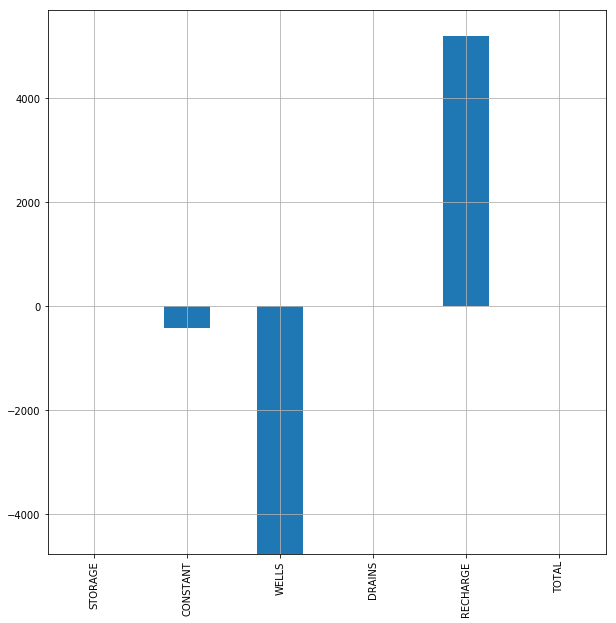

In [12]:
groups = df_flux.groupby(lambda x:x.split('_')[-1],axis=1).groups
df_flux_in = df_flux.loc[:,groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x:x.split('_')[0])

df_flux_out = df_flux.loc[:,groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x:x.split('_')[0])


df_flux_delta = df_flux_in - df_flux_out
df_flux_delta.iloc[-1,:].plot(kind="bar",figsize=(10,10),grid=True);

Let's look at head

In [13]:
# if you pass the model instance, then the plots will be offset and rotated
h = flopy.utils.HeadFile(os.path.join(model_ws,"freyberg.hds"),model=ml)
h.times

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

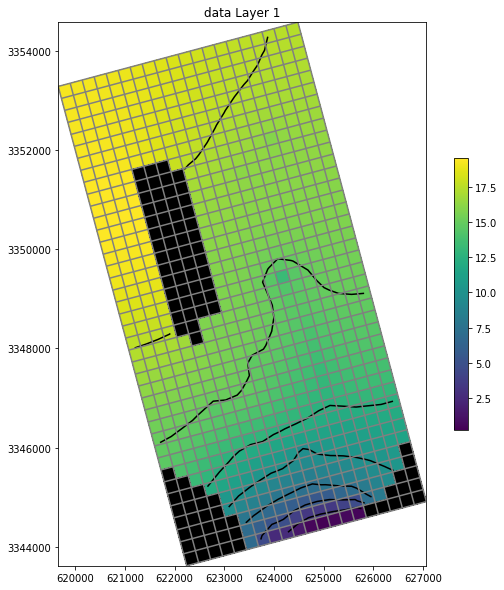

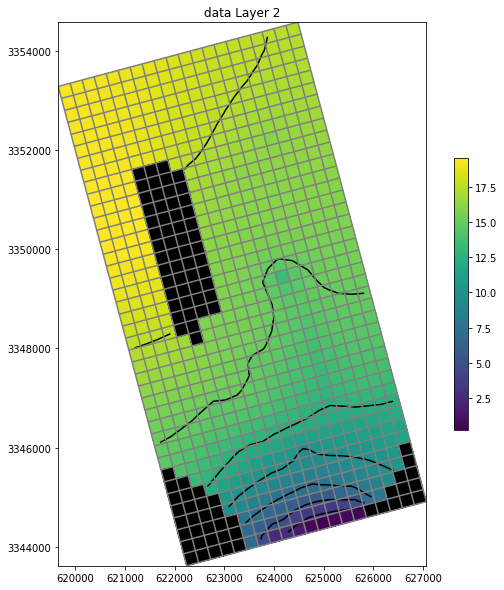

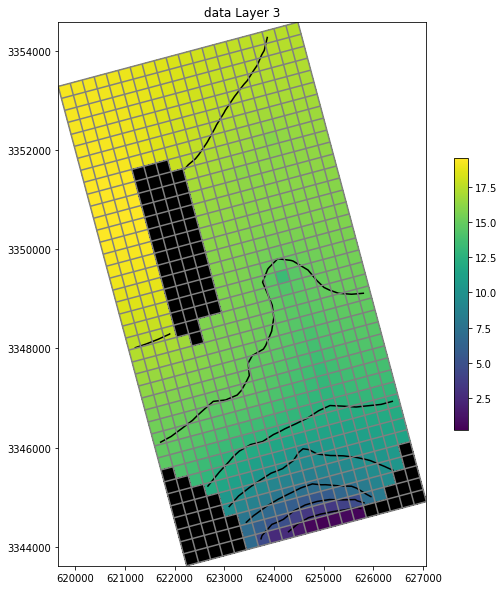

In [14]:
h.plot(totim=900, contour=True, grid=True, colorbar=True, figsize=(10,10));

### Write the heads to a shapefile

In [15]:
#let's write these heads to shapefile
h.to_shapefile(os.path.join(ml.model_ws,"freyburg_head.shp"))

wrote temp/freyburg_head.shp


### Let's make a movie of the model output

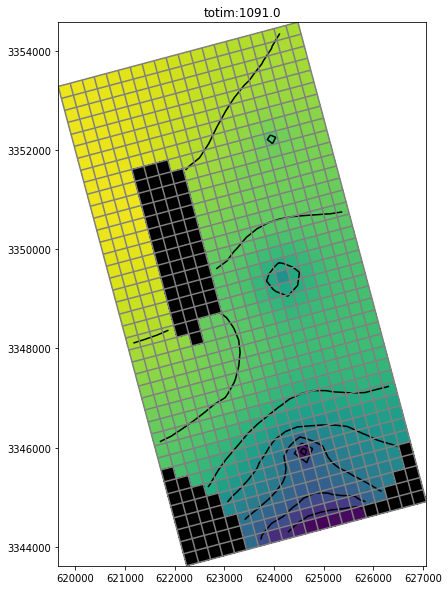

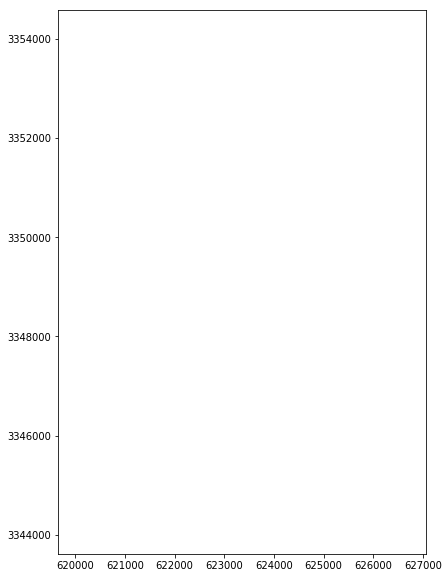

In [16]:
f = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1,aspect="equal")
for i,t in enumerate(h.times[0:-1:10]):
    ax.set_title("totim:{0}".format(t))
    h.plot(totim=t,mflay=0,contour=True,
           grid=True,figsize=(10,10),
            vmin=0,vmax=20,axes=[ax])
    time.sleep(0.001)
    clear_output(True)
    display(f)
    ax.cla()